# The finite element method <a class="tocSkip">

## Lecture 4: implementing a FEM solver in higher dimensions (Firedrake) <a class="tocSkip">
    
### Homework exercises <a class="tocSkip">

In [4]:
%precision 3
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
from mpltools import annotation
# as we're in 2D we will be doing some 3D plotting
from mpl_toolkits.mplot3d import Axes3D
# and using some colormaps
from matplotlib import cm
# and we will create some animations!
import matplotlib.animation as animation
from IPython.display import HTML
from pprint import pprint
import firedrake as fd

# Homework


## Homework - Laplacian smoothing

Consider the following mesh.

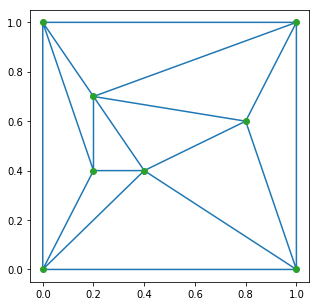

In [110]:
from scipy.spatial import Delaunay

points = np.array([[0.2,0.4],[0.2,0.7], [0.4,0.4], [0.8,0.6]])
# add corners
points = np.concatenate((points,[[0, 0], [0, 1], [1, 0], [1, 1]]))

tri = Delaunay(points, incremental=True)
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)

ax1.triplot(points[:, 0], points[:, 1], tri.simplices)
ax1.plot(points[:, 0], points[:, 1], 'o')

Write some code to implement ["Laplacian smoothing"](https://en.wikipedia.org/wiki/Laplacian_smoothing). 

This is an algorithm whereby every vertex of the mesh is visited in turn and its location is relocated to the mean of the locations of the vertices that are connected to it. This process is iterated until convergence. The idea is that this returns a mesh with improved mesh quality (NB. what we mean by quality is a somewhat complex issues but for our purposes we will consider triangles closer to equilateral to be of better quality).

Write a version of this mesh smoother that maintains the locations of the vertices at the four corners (i.e. so that the underlying "geometry" is maintained).

Also since we really do not want elements to go inverted (for vertices to pass through element faces), add an "under-relaxation" parameter that can help with robustness, but does mean we need more iterations. This means that rather than accepting the newly computed location, we choose a new location that is the weighted sum of the current and new positions - for a complex mesh (as in the next part of question) you may need to use a lot of under-relaxation in order to get a good result.

Once this works, test it out on a mesh generated using a Delaunay method (as above) generated from 20 random vertices arranged within the unit square (the use of random points will most likely lead to a "nasty" mesh with elements far from equilateral).  As in the first example add 4 corners which you maintain in their original locations in order to preserve a square geometry.

### Solution - Laplacian smoothing

An ideal solution should turn below into a function, and implement a user-defined stopping criteria rather than iterating for a fixed number of iterations.

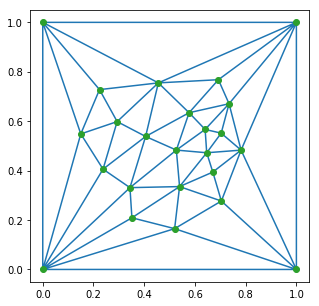

In [114]:
v0 = tri.vertex_neighbor_vertices[0]
v1 = tri.vertex_neighbor_vertices[1]
# under-relaxation parameter
relax = 0.1
for it in range(100):
    for i in range(points.shape[0]-4):
        average = np.mean(points[v1[v0[i]: v0[i+1]]], axis=0)
        # take a weighted sum of old and proposed locations
        points[i, :] = (1-relax)*points[i, :] + relax*average

        
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)

ax1.triplot(points[:, 0], points[:, 1], tri.simplices)
ax1.plot(points[:, 0], points[:, 1], 'o')

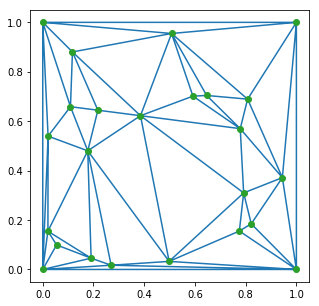

In [115]:
# generate a delaunay mesh from random points

points = np.random.rand(20,2)

# add in corners which we will fix in place to maintain an underlying geometry
points = np.concatenate((points,[[0, 0], [0, 1], [1, 0], [1, 1]]))

tri = Delaunay(points, incremental=True)

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)

ax1.triplot(points[:,0], points[:,1], tri.simplices)
ax1.plot(points[:,0], points[:,1], 'o')


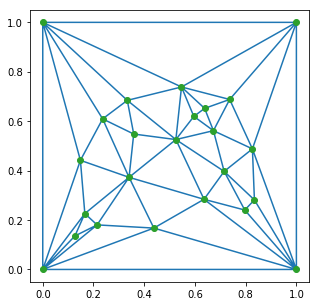

In [116]:
v0 = tri.vertex_neighbor_vertices[0]
v1 = tri.vertex_neighbor_vertices[1]
relax = 0.1
for it in range(1000):
    # don't loop over the 4 corners - could add a "geometry id" to do this in more complex cases
    for i in range(tri.points.shape[0]-4):
        average = np.mean(tri.points[v1[v0[i]: v0[i+1]]], axis=0)
        # take a weighted sum of old and proposed locations
        tri.points[i, :] = (1-relax)*tri.points[i, :] + relax*average

        
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)

ax1.triplot(tri.points[:, 0], tri.points[:, 1], tri.simplices)
ax1.plot(tri.points[:, 0], tri.points[:, 1], 'o')

## Homework - interpolation and projection using Firedrake

Let us consider the following step-wise function on the interval $[0,3]$

$$
  f(x) = 
  \begin{cases}
     0 & 0 \leq x \leq 1 \\
     1 & 1 \leq x \leq 2 \\
     2 & 2 \leq x \leq 3
  \end{cases}
$$

In Firedrake we could encode this function using the following expression:

In [109]:
import firedrake as fd
Nx = 10
mesh = fd.IntervalMesh(Nx, 0, 3)
x = fd.SpatialCoordinate(mesh)
f_expr = fd.conditional(x[0]<1, 0, fd.conditional(x[0]<2, 1, 2))

It should be noted that at this point `f_expr` does not actually use the grid points of the mesh, it just encodes 
the mathematical expression. The reason we need to define the mesh is because we need to say what the *domain* is (in the case the interval $[0,3]$) in which we are going to evaluate this expression.

Using the mesh however, we can now define a function space:

In [111]:
V = fd.FunctionSpace(mesh, "CG", 1)

Here "CG" stands for Continuous Galerkin, which means that we will be using piecewise continuous functions. The 1 refers to 
the polynomial degree: here we use linear polynomials. Thus the functions in $V$ are linear within each cell, and continuous going from one cell to the next. We could increase the polynomial degree to 2 to also use quadratic functions, etc. To allow the use of discontinuous functions we change "CG" to "DG" (for Discontinuous Galerkin).

We can now define a function in this function space, and interpolate `f_expr` onto it:

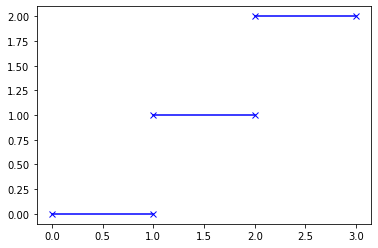

In [127]:
u = fd.Function(V)
u.interpolate(f_expr)

# plot the exact expression in three pieces:
plt.plot([0, 1], [0, 0], 'b-x')
plt.plot([1, 2], [1, 1], 'b-x')
plt.plot([2, 3], [2, 2], 'b-x');

In this interpolation the expression is evaluated at the nodes of the mesh, which are the points inbetween the subsequent cells. The function takes the linearly interpolated values between those values at the nodes.

In the lecture, we have seen the L2 projection as an alternative way to approximate an expression as closely as possible with piecewise linear functions on a given mesh. In Firedrake we can do this with:

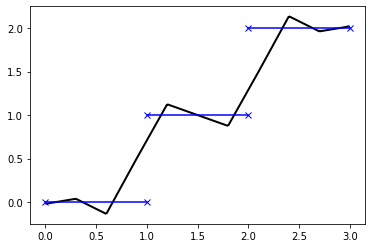

In [128]:
u_proj = fd.Function(V)
u_proj.project(f_expr)
x = fd.plot(u_proj)

# plot the exact expression in three pieces:
plt.plot([0, 1], [0, 0], 'b-x')
plt.plot([1, 2], [1, 1], 'b-x')
plt.plot([2, 3], [2, 2], 'b-x');

This approximation can be shown the most accurate (in the L2 norm). It does however not preserve the bounds of the original expression which can be a problem for some applications. For instance if the function represents a concentration it should not go negative.

### Exercise
Try interpolation and projection for a higher polynomial degree, and see what happens. Also try to use a Discontinuous Galerkin (DG) approximation and try to understand the difference. For the case of Discontinuous Galerkin, you can also use a polynomial degree of 0, which gives you a piecewise *constant* approximation.

## Homework - scalar advection using Firedrake

Continuing from the scalar advection example in the lecture, let us consider a slightly more challenging initial condition by adding two more features:
- a cone
- a slotted cylinder
This is a standard test case and benchmark used in the literature test advection schemes:

In [8]:
# the mesh: a unit square divided in 40x40x2 triangles
Nx = 40
Ny = Nx
mesh = fd.UnitSquareMesh(Nx, Ny)

# the function space in which we find the solution:
V = fd.FunctionSpace(mesh, "CG", 1)
# the function space used for the velocity field:
W = fd.VectorFunctionSpace(mesh, "CG", 1)

# the velocity field is a simple counter clockwise rotation around (0.5, 0.5)
x, y = fd.SpatialCoordinate(mesh)
velocity = fd.as_vector((0.5 - y, x - 0.5))
u = fd.Function(W).interpolate(velocity)

# the initial condition for the scalar function
bell_r0 = 0.15; bell_x0 = 0.25; bell_y0 = 0.5
bell = 0.25*(1+fd.cos(fd.pi*fd.min_value(fd.sqrt(pow(x-bell_x0, 2) + pow(y-bell_y0, 2))/bell_r0, 1.0)))

cone_r0 = 0.15; cone_x0 = 0.5; cone_y0 = 0.25
cone = 1.0 - fd.min_value(fd.sqrt(pow(x-cone_x0, 2) + pow(y-cone_y0, 2))/cyl_r0, 1.0)

cyl_r0 = 0.15; cyl_x0 = 0.5; cyl_y0 = 0.75
slot_left = 0.475; slot_right = 0.525; slot_top = 0.85
slot_cyl = fd.conditional(fd.sqrt(pow(x-cyl_x0, 2) + pow(y-cyl_y0, 2)) < cyl_r0,
             fd.conditional(fd.And(fd.And(x > slot_left, x < slot_right), y < slot_top),
               0.0, 1.0), 0.0)


q = fd.Function(V).interpolate(1.0 + bell + cone + slot_cyl)
q_init = fd.Function(V).assign(q)

# We will run for time `2\pi`, a full rotation.  We take 600 steps, giving
# a timestep close to the CFL limit.  We declare an extra variable ``dtc``; for
# technical reasons, this means that Firedrake does not have to compile new C code
# if the user tries different timesteps.  Finally, we define the inflow boundary
# condition, q = q_in.
T = 2*fd.pi
dt = T/600.0
dtc = fd.Constant(dt)
q_in = fd.Constant(1.0)

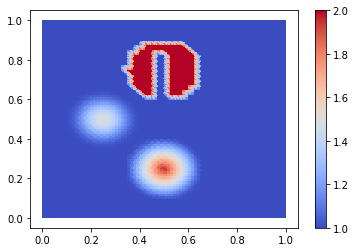

In [16]:
fd.plot(q_init);

### Exercise
Run the scalar advection code from the lecture with this initial condition. What do you observe?

## Homework - scalar advection using a Discontinuous Galerkin scheme
As we have seen before it is very easy in Firedrake to switch function spaces, from e.g. a continuous to a discontinuous function space. However this is in general not sufficient to change a Continuous Galerkin (CG) formulation into a Discontinuous Galerkin (DG) scheme. The reason is that we made a step in the derivation of our weak formulation, that is not valid for discontinuous functions: when we integrate by parts we need to take into account the discontinuities across element boundaries.

Restricted to a single element however, our weak formulation is still valid. When we apply integration by parts on an element-by-element basis we get boundary terms integrated over the boundaries of the elements! (i.e. the edges in the mesh). Just like with a continuous formulation applied to the entire domain, we now need to apply boundary conditions on each element indidivually - where in the case of advection we need to set a Dirichlet condition for the incoming scalar. Where does the boundary value come from? Again in the case of advection, the natural choice is to use the value of $q$ that is computed for the upwind cell on that boundary.

These extra *internal* boundary terms are often refered to as "jump" terms (they can be seen to apply a jump condition on the discontinuity across two elements). In our case we only need to add one single extra line to the definition of `L1` which also contains one more auxillary variable `un`:

In [13]:
un = 0.5*(fd.dot(u, n) + abs(fd.dot(u, n)))

L1 = dtc*(q*fd.div(phi*u)*fd.dx
          - fd.conditional(fd.dot(u, n) < 0, phi*fd.dot(u, n)*q_in, 0.0)*fd.ds
          - fd.conditional(fd.dot(u, n) > 0, phi*fd.dot(u, n)*q, 0.0)*fd.ds
          - (phi('+') - phi('-'))*(un('+')*q('+') - un('-')*q('-'))*fd.dS)

Here the `fd.dS` indicates integration over the internal boundaries (all the edges). The `'+'` and `'-'` refer to either side of an edge. The definition of `un` is based on the following formula:

$$
  {\tt un} = \begin{cases} \vec u\cdot\vec n & \vec u\cdot\vec n \gt 0 \\
  0 & \vec u\cdot\vec n\leq 0 \end{cases}
$$

Thus `un` is only nonzero on the upwind side of an edge.

### Exercise
Make the necessary changes to the advection code to run the above initial condition with a DG scheme. Apart from the change to L1, you also need to change the function space `V` (and thus repeat the code for the initial condition).

What difference do you observe between the CG and the DG scheme?